In [14]:
import astropy.io.fits as fits
import numpy as np
from scipy.integrate import quad
import scipy.integrate as integrate
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import Table, join
import os
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
import halomod as hm
import hmf
import treecorr

In [15]:
import DarkVerse as dv
%matplotlib inline
plt.rc('font',**{'family':'serif','size':14})
#plt.rc('text', usetex=True)


In [16]:
home_dir = os.path.expanduser('~')
directory_SN_X3 = "/home/astro/manasoi7/Master_Thesis/Results/SN-X3"
directory_SN_C3 = "/home/astro/manasoi7/Master_Thesis/Results/SN-C3"
directory_SN_E2 = "/home/astro/manasoi7/Master_Thesis/Results/SN-E2" 
directory_COSMOS = "/home/astro/manasoi7/Master_Thesis/Results/COSMOS" 
res = os.path.join(home_dir, 'Master_Thesis', 'Results')

# Now trying all my fields 

### SM Completeness (for COMSMOS)
\begin{array}{c|c}
\textbf{Redshift Range}~(z) & \textbf{Mass Limit}~\log_{10}(M_*/M_\odot) \\
\hline
0.1 & 7.44 \\
0.2 & 7.87 \\
0.3 & 8.23 \\
0.4 & 8.41 \\
0.5  & 8.61 \\
0.6 & 8.85 \\
0.7 & 9.09 \\
0.8 & 9.41 \\
0.9 & 9.63 \\
1.0 & 9.76 \\
\end{array}


<>:143: SyntaxWarning: invalid escape sequence '\i'
<>:143: SyntaxWarning: invalid escape sequence '\i'
/tmp/ipykernel_1856111/2126814310.py:143: SyntaxWarning: invalid escape sequence '\i'
  ax.set_title(f'$w(\\theta)$ for $10^{{{SM_min}}} < M_*$, $z \in [{z_min},{z_max}]$', fontsize=14)




🔹 Processing stellar mass bin 9.5–10.5

🔸 Processing field: SN-X3
HOD fit results: M_min = 10^11.38, M_1 = 10^12.53, alpha = 0.63


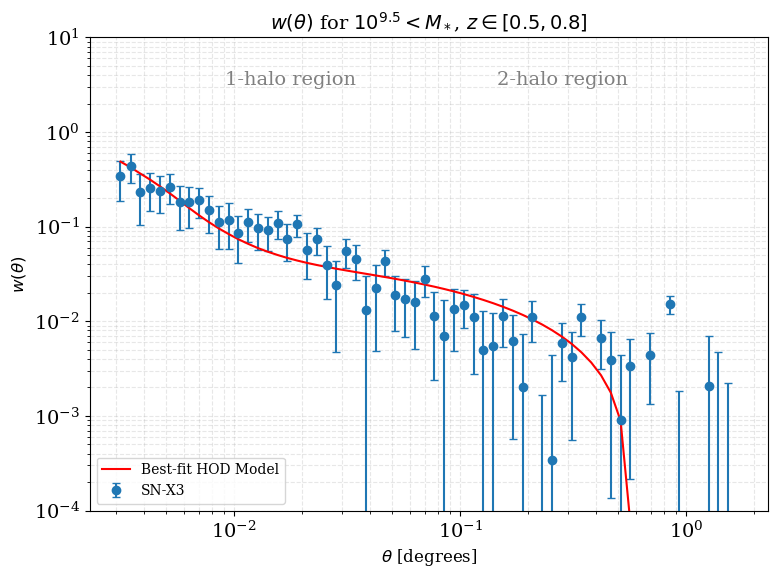

  ➤ bias_eff = 1.130

🔸 Processing field: SN-C3
HOD fit results: M_min = 10^12.39, M_1 = 10^13.95, alpha = 1.91


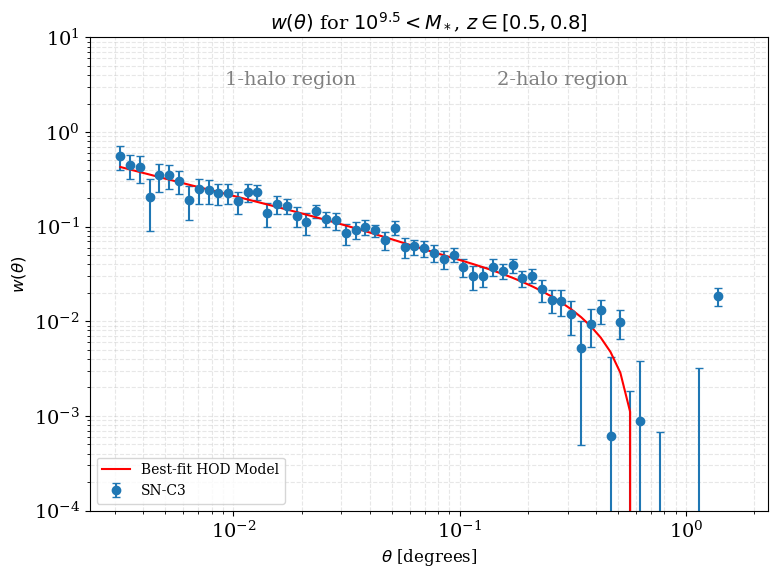

  ➤ bias_eff = 1.646

🔸 Processing field: SN-E2
HOD fit results: M_min = 10^11.00, M_1 = 10^12.99, alpha = 1.60


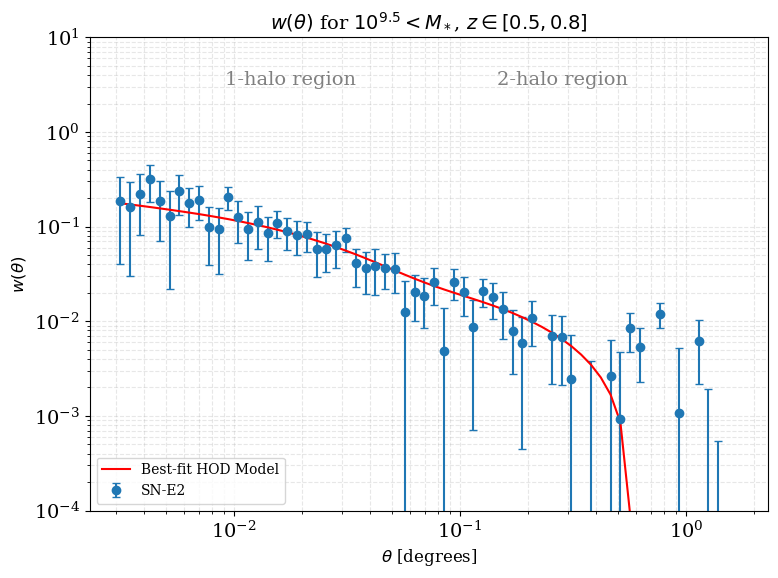

  ➤ bias_eff = 1.098

🔸 Processing field: COSMOS
HOD fit results: M_min = 10^12.36, M_1 = 10^14.01, alpha = 2.00


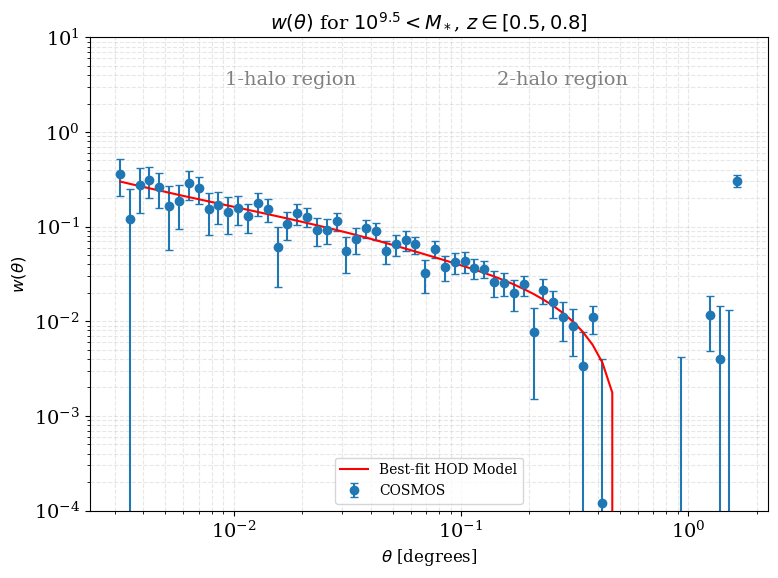

  ➤ bias_eff = 1.601

Individual Field Results:
SN-X3: b = 1.273 ± 0.052, IC = 0.0078
SN-C3: b = 1.700 ± 0.029, IC = 0.0126
SN-E2: b = 1.304 ± 0.038, IC = 0.0079
COSMOS: b = 1.699 ± 0.032, IC = 0.0159

Global bias estimate: 1.351 ± 0.016


🔹 Processing stellar mass bin 10.5–12.5

🔸 Processing field: SN-X3
HOD fit results: M_min = 10^11.45, M_1 = 10^12.50, alpha = 0.87


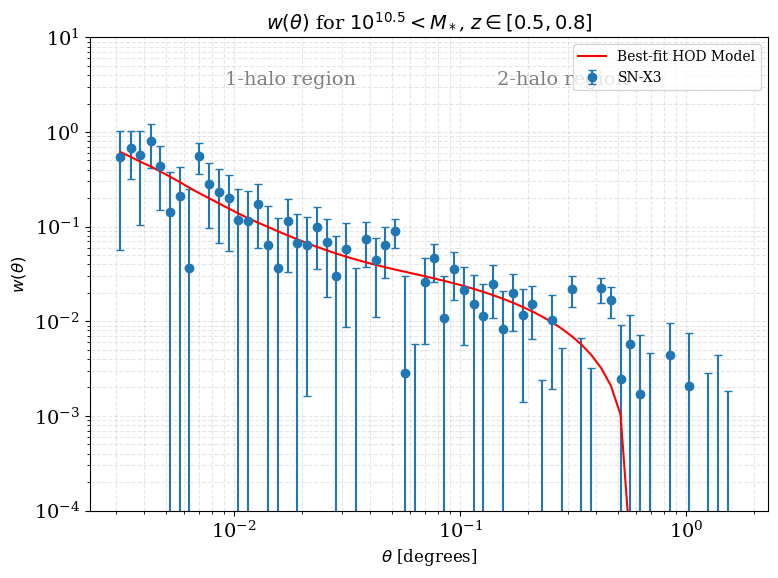

  ➤ bias_eff = 1.244

🔸 Processing field: SN-C3
HOD fit results: M_min = 10^12.78, M_1 = 10^14.13, alpha = 1.90


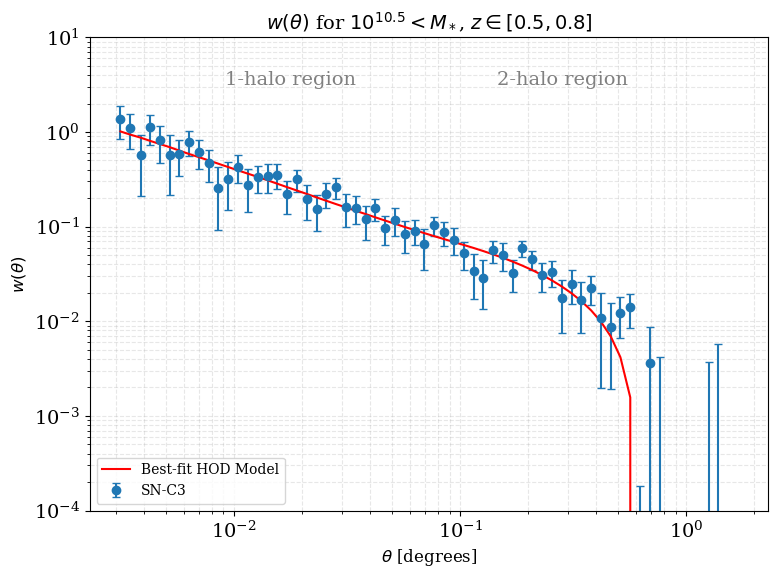

  ➤ bias_eff = 1.998

🔸 Processing field: SN-E2
HOD fit results: M_min = 10^11.93, M_1 = 10^13.33, alpha = 1.30


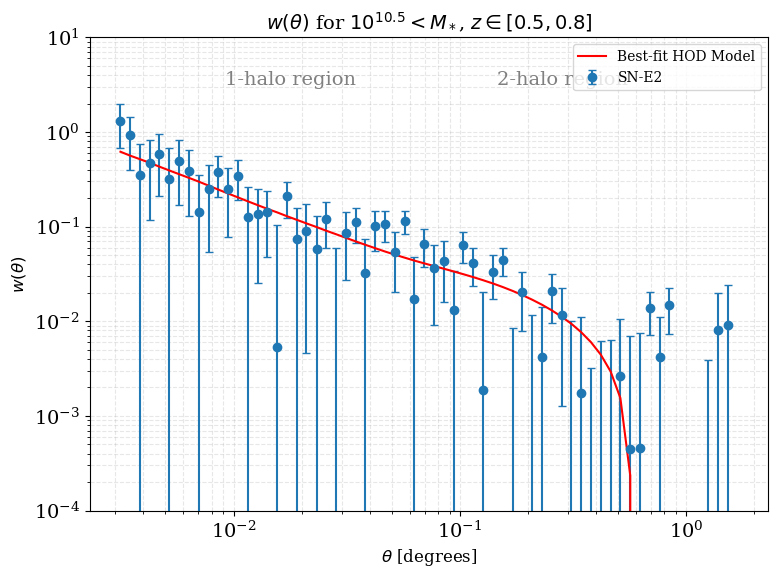

  ➤ bias_eff = 1.434

🔸 Processing field: COSMOS
HOD fit results: M_min = 10^12.19, M_1 = 10^13.66, alpha = 1.46


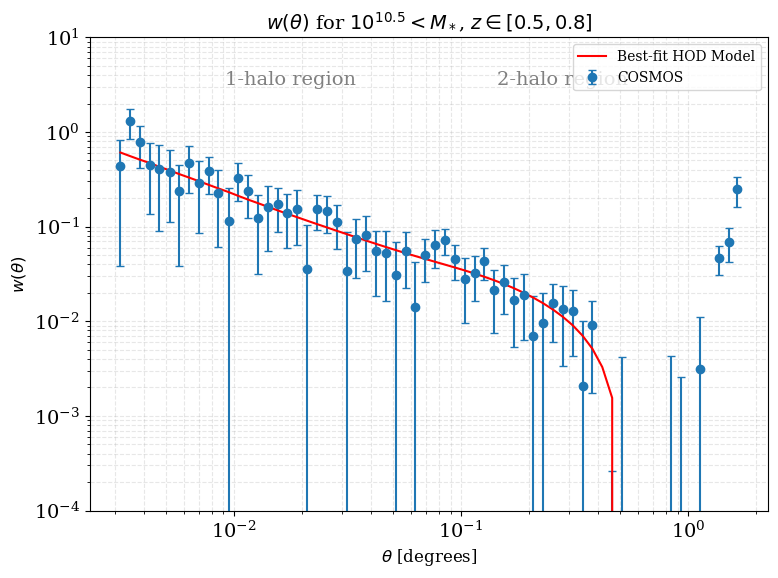

  ➤ bias_eff = 1.543

Individual Field Results:
SN-X3: b = 1.386 ± 0.071, IC = 0.0092
SN-C3: b = 1.940 ± 0.060, IC = 0.0165
SN-E2: b = 1.487 ± 0.094, IC = 0.0103
COSMOS: b = 1.643 ± 0.040, IC = 0.0148

Global bias estimate: 1.531 ± 0.036


In [17]:
home_dir = os.path.expanduser('~')
thesis_path = os.path.join(home_dir, 'Master_Thesis', 'DATA')

stellar_masses = []
halo_masses = []

# Field details
fields = {
    "SN-X3": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_SN-X3_zm.fits",
        "masked": "SN-X3_masked_cat.fits",
        "randoms": "SN-X3_randoms_ugriz_trim_video.fits"
    },
    "SN-C3": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_SN-C3_zm.fits",
        "masked": "SN-C3_masked_cat.fits",
        "randoms": "SN-C3_randoms_ugriz_trim_video.fits"
    },
    "SN-E2": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_SN-E2_zm.fits",
        "masked": "SN-E2_masked_cat.fits",
        "randoms": "SN-E2_randoms_ugriz_trim_video.fits"
    },
    "COSMOS": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_COSMOS_zm.fits",
        "masked": "COSMOS_masked_cat.fits",
        "randoms": "COSMOS_randoms_ugriz_trim_video.fits"
    }
}
config = {
    'min_sep': 0.003, 
    'max_sep': 1.78, 
    #'nbins': 10,
    'bin_size': 0.1,
    'sep_units': 'degrees',
    'var_method': 'shot'   # if using the internal 'var_method': 'bootstrap' of treecrorr, but then it takes a long time to run
}

# Fixed redshift range
#z_min, z_max = 0.2, 0.5
z_min, z_max = 0.5, 0.8


# Define stellar mass bins
#SM_bins = [(8.17, 8.6), (8.6, 9.0), (9.0, 9.6), (9.6, 10.5), (10.5, 12.5)]
#SM_bins = [(10.5, 12.5)]

#SM_bins = [ (8, 9), (9, 10), (10, 11), (11, 12.5)]

SM_bins = [ (9.5, 10.5), (10.5, 12.5)]


#colors = ["blue", "green", "red", "purple", "orange"]
colors = {
    "SN-C3": "tab:blue",
    "SN-X3": "tab:orange",
    "COSMOS": "tab:red",
    "SN-E2": "tab:green"
}

# Initialize storage
all_results = {sm_range: {} for sm_range in SM_bins}

# Process each stellar mass bin
for SM_min, SM_max in SM_bins:
    print(f"\n\n🔹 Processing stellar mass bin {SM_min}–{SM_max}")
    
    # Initialize bias estimator with the first field
    first_field = list(fields.keys())[0]
    first_catalog = Table.read(os.path.join(thesis_path, fields[first_field]["catalog"]))
    first_masked = Table.read(os.path.join(thesis_path, fields[first_field]["masked"]))
    first_catalog = join(first_catalog, first_masked, keys='id')
    first_catalog.rename_columns(['ra_1', 'dec_1'], ['ra', 'dec'])
    first_randoms = Table.read(os.path.join(thesis_path, fields[first_field]["randoms"]))
    
    first_subsample = dv.Selection(
        catalog=first_catalog,
        randoms=first_randoms,
        z_min=z_min,
        z_max=z_max,
        SM_min=SM_min,
        SM_max=SM_max,
        config=config
    )
    first_results = first_subsample.get_results()
    
    estimator = dv.FieldBiasEstimator(
        xi_m=np.array(first_results['xi_m']),
        mask=(np.array(first_results['theta']) >= 0.1) & (np.array(first_results['theta']) <= 0.4)
    )
    
    bias_eff_dict = {}

    # Process all fields
    for field, paths in fields.items():
        print(f"\n🔸 Processing field: {field}")
        
        catalog = Table.read(os.path.join(thesis_path, paths["catalog"]))
        masked = Table.read(os.path.join(thesis_path, paths["masked"]))
        catalog = join(catalog, masked, keys='id') # Join masked and catalog
        catalog.rename_columns(['ra_1', 'dec_1'], ['ra', 'dec'])
        randoms = Table.read(os.path.join(thesis_path, paths["randoms"]))
        
        subsample = dv.Selection(
            catalog=catalog,
            randoms=randoms,
            z_min=z_min,
            z_max=z_max,
            SM_min=SM_min,
            SM_max=SM_max,
            config=config
        )

        #hod_params, pcov, pdict = subsample.fit_hod()
        #print(f"  ➤ fit diagnostics: {pdict['message']} (success={pdict['success']}, nfev={pdict['nfev']})")
        
        # HOD fitting for this stellar mass bin        
        hod_params, pcov = subsample.fit_hod()
        
        results = subsample.get_results()
        theta = results['theta']
        w_theta = results['w_theta']
        w_theta_error=np.sqrt(np.array(results['var_w_theta_bootstrap']))

        
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.errorbar(theta, w_theta, yerr=w_theta_error, fmt='o', label= field, capsize=3)

        
        logM_min, logM_1, alpha = results['hod_params']
        print(f"HOD fit results: M_min = 10^{logM_min*1e7:.2f}, "
              f"M_1 = 10^{logM_1:.2f}, alpha = {alpha:.2f}")
        
        w_model = subsample.hod_model(logM_min *1e7, logM_1, alpha) 
        ax.plot(theta, w_model, label='Best-fit HOD Model', color='red')
        
        xi_m_values = subsample.get_results()['xi_m']
        # ax.plot(theta, xi_m_values, label=r'$\omega_{dm}(\theta)$ (Matter)', linestyle='dashed', color='black')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlabel(r'$\theta$ [degrees]', fontsize=12)
        ax.set_ylabel(r'$w(\theta)$', fontsize=12)
        ax.set_title(f'$w(\\theta)$ for $10^{{{SM_min}}} < M_*$, $z \in [{z_min},{z_max}]$', fontsize=14)
    
        ax.set_ylim([1e-4, 10])
        ax.legend(fontsize=10, framealpha=0.8)
        ax.grid(True, which="both", ls="--", alpha=0.3)
    
        # Optional annotations
        ax.text(0.2, 0.9, "1-halo region", transform=ax.transAxes, color='gray')
        ax.text(0.6, 0.9, "2-halo region", transform=ax.transAxes, color='gray')
    
        plt.tight_layout()
        #plt.savefig(f"wtheta_{field}_HOD_SM_{SM_min}_{SM_max}.png")
        plt.show()


        
        bias_eff = subsample.gg.bias_effective_tracer
        bias_eff_dict[field] = bias_eff
        print(f"  ➤ bias_eff = {bias_eff:.3f}")


        
        estimator.add_field(
            field_name=field,
            xi_g=np.array(results['xi_g']),
            w_theta=np.array(results['w_theta']),
            w_theta_error=np.sqrt(np.array(results['var_w_theta_bootstrap'])),
            sum_rr=np.array(results['rr_counts'])
        )
        
        # Compute stellar-to-halo mass ratio
        logM_star = SM_min  # log stellar mass threshold
        logM_halo = logM_min *1e7  # From HOD fit
        M_star = 10**logM_star
        M_halo = 10**logM_halo
        stellar_masses.append(M_star)
        halo_masses.append(M_halo)
        


    
    print("\nIndividual Field Results:")
    individual_results = estimator.fit_individual_fields()
    for name, b, be, ic in individual_results:
        print(f"{name}: b = {b:.3f} ± {be:.3f}, IC = {ic:.4f}")
    
    global_b, global_be = estimator.fit_combined()
    print(f"\nGlobal bias estimate: {global_b:.3f} ± {global_be:.3f}")
    
    all_results[(SM_min, SM_max)] = {
        'individual': individual_results,
        'global_b': global_b,
        'global_be': global_be,
        'estimator': estimator,
        'bias_eff': bias_eff_dict,
        'logM_min': logM_min 
    }



    

<>:143: SyntaxWarning: invalid escape sequence '\i'
<>:143: SyntaxWarning: invalid escape sequence '\i'
/tmp/ipykernel_1856111/441895585.py:143: SyntaxWarning: invalid escape sequence '\i'
  ax.set_title(f'$w(\\theta)$ for $10^{{{SM_min}}} < M_*$, $z \in [{z_min},{z_max}]$', fontsize=14)




🔹 Processing stellar mass bin 8.6–9
The following patch numbers have no objects: {30}
This may be a problem depending on your use case.

🔸 Processing field: SN-X3
The following patch numbers have no objects: {29}
This may be a problem depending on your use case.
HOD fit results: M_min = 10^11.04, M_1 = 10^12.98, alpha = 0.47


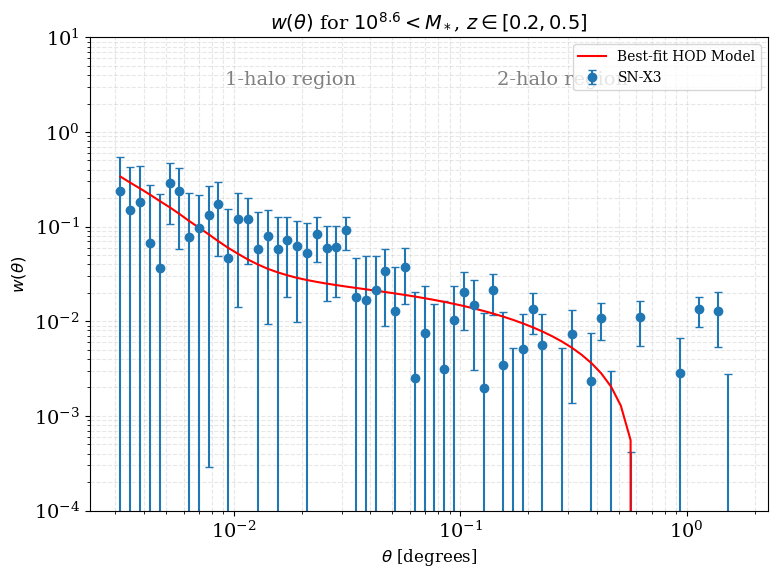

  ➤ bias_eff = 0.870

🔸 Processing field: SN-C3
HOD fit results: M_min = 10^11.23, M_1 = 10^13.38, alpha = 1.67


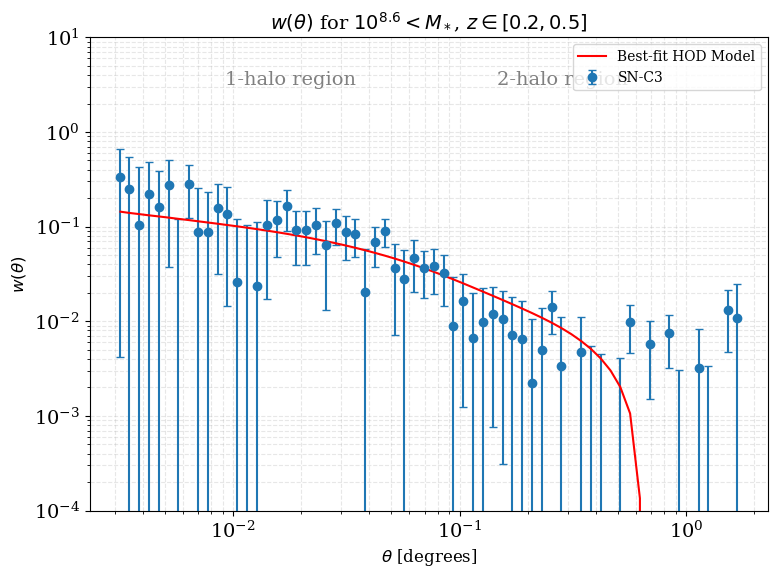

  ➤ bias_eff = 1.003

🔸 Processing field: SN-E2
HOD fit results: M_min = 10^11.98, M_1 = 10^15.50, alpha = 1.99


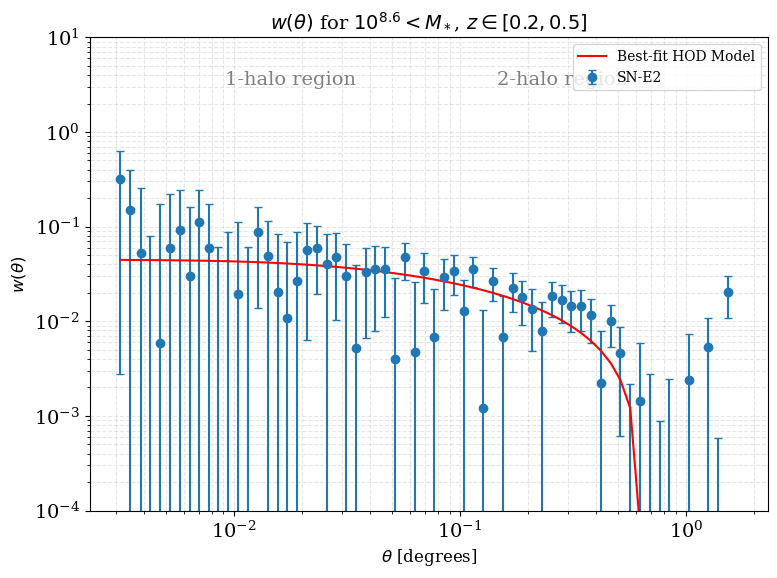

  ➤ bias_eff = 1.102

🔸 Processing field: COSMOS
HOD fit results: M_min = 10^11.00, M_1 = 10^12.94, alpha = 1.00


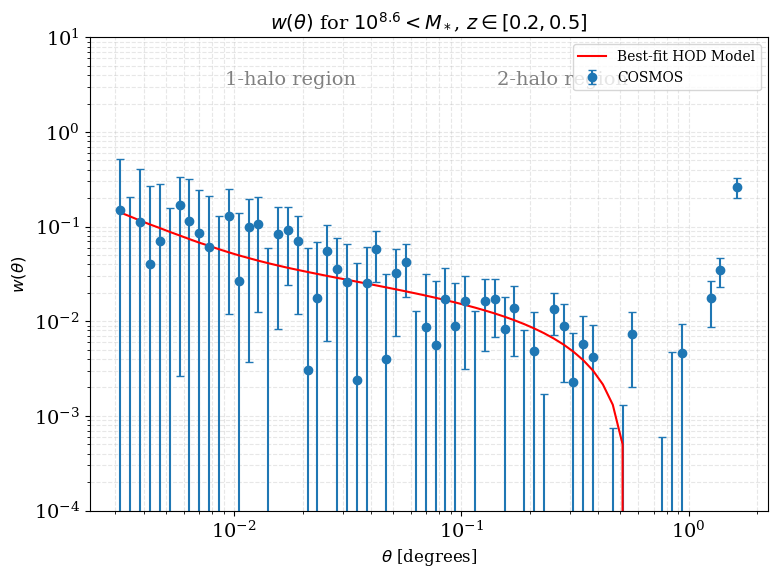

  ➤ bias_eff = 0.902

Individual Field Results:
SN-X3: b = 1.171 ± 0.040, IC = 0.0136
SN-C3: b = 1.164 ± 0.034, IC = 0.0126
SN-E2: b = 1.371 ± 0.048, IC = 0.0183
COSMOS: b = 1.300 ± 0.043, IC = 0.0188

Global bias estimate: 1.056 ± 0.022


🔹 Processing stellar mass bin 9–10

🔸 Processing field: SN-X3


In [ ]:
home_dir = os.path.expanduser('~')
thesis_path = os.path.join(home_dir, 'Master_Thesis', 'DATA')

stellar_masses = []
halo_masses = []

# Field details
fields = {
    "SN-X3": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_SN-X3_zm.fits",
        "masked": "SN-X3_masked_cat.fits",
        "randoms": "SN-X3_randoms_ugriz_trim_video.fits"
    },
    "SN-C3": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_SN-C3_zm.fits",
        "masked": "SN-C3_masked_cat.fits",
        "randoms": "SN-C3_randoms_ugriz_trim_video.fits"
    },
    "SN-E2": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_SN-E2_zm.fits",
        "masked": "SN-E2_masked_cat.fits",
        "randoms": "SN-E2_randoms_ugriz_trim_video.fits"
    },
    "COSMOS": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_COSMOS_zm.fits",
        "masked": "COSMOS_masked_cat.fits",
        "randoms": "COSMOS_randoms_ugriz_trim_video.fits"
    }
}
config = {
    'min_sep': 0.003, 
    'max_sep': 1.78, 
    #'nbins': 10,
    'bin_size': 0.1,
    'sep_units': 'degrees',
    'var_method': 'shot'   # if using the internal 'var_method': 'bootstrap' of treecrorr, but then it takes a long time to run
}

# Fixed redshift range
z_min, z_max = 0.2, 0.5
#z_min, z_max = 0.5, 0.8


# Define stellar mass bins
#SM_bins = [(8.17, 8.6), (8.6, 9.0), (9.0, 9.6), (9.6, 10.5), (10.5, 12.5)]
#SM_bins = [(10.5, 12.5)]

SM_bins = [ (8.6, 9), (9, 10), (10, 11), (11, 12.5)]

#SM_bins = [ (9.5, 10.5), (10.5, 12.5)]


#colors = ["blue", "green", "red", "purple", "orange"]
colors = {
    "SN-C3": "tab:blue",
    "SN-X3": "tab:orange",
    "COSMOS": "tab:red",
    "SN-E2": "tab:green"
}

# Initialize storage
all_results = {sm_range: {} for sm_range in SM_bins}

# Process each stellar mass bin
for SM_min, SM_max in SM_bins:
    print(f"\n\n🔹 Processing stellar mass bin {SM_min}–{SM_max}")
    
    # Initialize bias estimator with the first field
    first_field = list(fields.keys())[0]
    first_catalog = Table.read(os.path.join(thesis_path, fields[first_field]["catalog"]))
    first_masked = Table.read(os.path.join(thesis_path, fields[first_field]["masked"]))
    first_catalog = join(first_catalog, first_masked, keys='id')
    first_catalog.rename_columns(['ra_1', 'dec_1'], ['ra', 'dec'])
    first_randoms = Table.read(os.path.join(thesis_path, fields[first_field]["randoms"]))
    
    first_subsample = dv.Selection(
        catalog=first_catalog,
        randoms=first_randoms,
        z_min=z_min,
        z_max=z_max,
        SM_min=SM_min,
        SM_max=SM_max,
        config=config
    )
    first_results = first_subsample.get_results()
    
    estimator = dv.FieldBiasEstimator(
        xi_m=np.array(first_results['xi_m']),
        mask=(np.array(first_results['theta']) >= 0.1) & (np.array(first_results['theta']) <= 0.4)
    )
    
    bias_eff_dict = {}

    # Process all fields
    for field, paths in fields.items():
        print(f"\n🔸 Processing field: {field}")
        
        catalog = Table.read(os.path.join(thesis_path, paths["catalog"]))
        masked = Table.read(os.path.join(thesis_path, paths["masked"]))
        catalog = join(catalog, masked, keys='id') # Join masked and catalog
        catalog.rename_columns(['ra_1', 'dec_1'], ['ra', 'dec'])
        randoms = Table.read(os.path.join(thesis_path, paths["randoms"]))
        
        subsample = dv.Selection(
            catalog=catalog,
            randoms=randoms,
            z_min=z_min,
            z_max=z_max,
            SM_min=SM_min,
            SM_max=SM_max,
            config=config
        )

        #hod_params, pcov, pdict = subsample.fit_hod()
        #print(f"  ➤ fit diagnostics: {pdict['message']} (success={pdict['success']}, nfev={pdict['nfev']})")
        
        # HOD fitting for this stellar mass bin        
        hod_params, pcov = subsample.fit_hod()
        
        results = subsample.get_results()
        theta = results['theta']
        w_theta = results['w_theta']
        w_theta_error=np.sqrt(np.array(results['var_w_theta_bootstrap']))

        
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.errorbar(theta, w_theta, yerr=w_theta_error, fmt='o', label= field, capsize=3)

        
        logM_min, logM_1, alpha = results['hod_params']
        print(f"HOD fit results: M_min = 10^{logM_min*1e7:.2f}, "
              f"M_1 = 10^{logM_1:.2f}, alpha = {alpha:.2f}")
        
        w_model = subsample.hod_model(logM_min *1e7, logM_1, alpha) 
        ax.plot(theta, w_model, label='Best-fit HOD Model', color='red')
        
        xi_m_values = subsample.get_results()['xi_m']
        # ax.plot(theta, xi_m_values, label=r'$\omega_{dm}(\theta)$ (Matter)', linestyle='dashed', color='black')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlabel(r'$\theta$ [degrees]', fontsize=12)
        ax.set_ylabel(r'$w(\theta)$', fontsize=12)
        ax.set_title(f'$w(\\theta)$ for $10^{{{SM_min}}} < M_*$, $z \in [{z_min},{z_max}]$', fontsize=14)
    
        ax.set_ylim([1e-4, 10])
        ax.legend(fontsize=10, framealpha=0.8)
        ax.grid(True, which="both", ls="--", alpha=0.3)
    
        # Optional annotations
        ax.text(0.2, 0.9, "1-halo region", transform=ax.transAxes, color='gray')
        ax.text(0.6, 0.9, "2-halo region", transform=ax.transAxes, color='gray')
    
        plt.tight_layout()
        #plt.savefig(f"wtheta_{field}_HOD_SM_{SM_min}_{SM_max}.png")
        plt.show()


        
        bias_eff = subsample.gg.bias_effective_tracer
        bias_eff_dict[field] = bias_eff
        print(f"  ➤ bias_eff = {bias_eff:.3f}")


        
        estimator.add_field(
            field_name=field,
            xi_g=np.array(results['xi_g']),
            w_theta=np.array(results['w_theta']),
            w_theta_error=np.sqrt(np.array(results['var_w_theta_bootstrap'])),
            sum_rr=np.array(results['rr_counts'])
        )
        
        # Compute stellar-to-halo mass ratio
        logM_star = SM_min  # log stellar mass threshold
        logM_halo = logM_min *1e7  # From HOD fit
        M_star = 10**logM_star
        M_halo = 10**logM_halo
        stellar_masses.append(M_star)
        halo_masses.append(M_halo)
        


    
    print("\nIndividual Field Results:")
    individual_results = estimator.fit_individual_fields()
    for name, b, be, ic in individual_results:
        print(f"{name}: b = {b:.3f} ± {be:.3f}, IC = {ic:.4f}")
    
    global_b, global_be = estimator.fit_combined()
    print(f"\nGlobal bias estimate: {global_b:.3f} ± {global_be:.3f}")
    
    all_results[(SM_min, SM_max)] = {
        'individual': individual_results,
        'global_b': global_b,
        'global_be': global_be,
        'estimator': estimator,
        'bias_eff': bias_eff_dict,
        'logM_min': logM_min 
    }




In [ ]:
# Plot SM vs Halo Mass
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(halo_masses, stellar_masses, marker='o', linestyle='-', color='purple', label='SHMR from HOD fit')
ax.set_title(f'Stellar-to-Halo Mass Ratio (SHMR), $z \in [{z_min},{z_max}]$', fontsize=14)


ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$M_{\rm halo}$', fontsize=12)
ax.set_ylabel(r'$M_*$', fontsize=12)
ax.legend()
plt.show()

# Shuntov data  $z \in [0.2, 0.5]$

In [ ]:
shuntov_data = {
    (10.5, 12.5): {
        "theta": np.array([
            8.6213e-04, 1.8266e-03, 3.8500e-03, 8.4446e-03,
            1.9095e-02, 4.1869e-02, 9.3389e-02, 2.0352e-01,
            4.3985e-01, 8.6697e-01
        ]),
        "wtheta": np.array([
            4.0512, 2.1335, 0.76826, 0.60844,
            0.23972, 0.064465, 0.021901, 0.0086372,
            0.0026260, -0.0046342
        ]),
        "error": np.array([
            1.4703, 0.58440, 0.19946, 0.11059,
            0.10579, 0.051982, 0.018514, 0.012101,
            0.0047944, 0.0036775
        ])
    },
    (9.6, 10.5): {
        "theta": np.array([
            8.6177e-04, 1.8088e-03, 3.9387e-03, 8.6512e-03,
            1.9151e-02, 4.2155e-02, 9.3135e-02, 2.0382e-01,
            4.4044e-01, 8.6983e-01
        ]),
        "wtheta": np.array([
            2.4589, 1.4099, 0.66725, 0.40769,
            0.18806, 0.072816, 0.011834, 0.0077454,
            0.0029769, -0.0041483
        ]),
        "error": np.array([
            0.35086, 0.11457, 0.070194, 0.052862,
            0.046929, 0.022189, 0.0089981, 0.0070251,
            0.0029207, 0.0022315
        ])
    },
    (9.0, 9.6): {
        "theta": np.array([
            8.3259e-04, 1.8063e-03, 3.9674e-03, 8.7145e-03,
            1.9194e-02, 4.2263e-02, 9.3085e-02, 2.0379e-01,
            4.4007e-01, 8.6861e-01
        ]),
        "wtheta": np.array([
            1.2910, 0.97706, 0.52575, 0.33105,
            0.15498, 0.061639, 0.012956, 0.0081038,
            0.0026256, -0.0043871
        ]),
        "error": np.array([
            0.16438, 0.080514, 0.037668, 0.037046,
            0.029617, 0.016203, 0.0084722, 0.0077168,
            0.0032781, 0.0026839
        ])
    },
    (8.6, 9.0): {
        "theta": np.array([
            8.4966e-04, 1.8031e-03, 3.9695e-03, 8.7495e-03,
            1.9216e-02, 4.2306e-02, 9.3108e-02, 2.0376e-01,
            4.4003e-01, 8.6822e-01
        ]),
        "wtheta": np.array([
            0.86374, 0.76856, 0.43005, 0.26244,
            0.13492, 0.050636, 0.012632, 0.0066597,
            0.0023886, -0.0037334
        ]),
        "error": np.array([
            0.098497, 0.043001, 0.033822, 0.023979,
            0.019220, 0.011188, 0.0070628, 0.0067357,
            0.0029484, 0.0024237
        ])
    },
    (8.17, 8.6): {
        "theta": np.array([
            8.4620e-04, 1.8016e-03, 3.9815e-03, 8.7588e-03,
            1.9257e-02, 4.2327e-02, 9.3100e-02, 2.0381e-01,
            4.4014e-01, 8.6768e-01
        ]),
        "wtheta": np.array([
            0.60852, 0.56341, 0.32357, 0.19411,
            0.10953, 0.040942, 0.012872, 0.0058622,
            0.0021337, -0.0033312
        ]),
        "error": np.array([
            0.057764, 0.029369, 0.022334, 0.019434,
            0.014293, 0.0085523, 0.0054175, 0.0060078,
            0.0021963, 0.0020317
        ])
    }
}


In [ ]:
for (SM_min, SM_max), result in all_results.items():

    estimator = result['estimator']
    fig, ax = plt.subplots(figsize=(8, 6))

    # Retrieve Shuntov data
    shuntov = shuntov_data[(SM_min, SM_max)]
    shuntov_theta = shuntov["theta"]
    shuntov_wtheta = shuntov["wtheta"]
    shuntov_error = shuntov["error"]

    # Plot COSMOS measurements
    for field_data in estimator.fields:
        #if field_data['name'] != 'COSMOS':
            #continue

        results = subsample.get_results()
        theta = results['theta']

        #theta = shuntov_theta  # Use same θ as Shuntov
        w_theta = field_data['w_theta']
        w_theta_err = field_data['w_error']

        ax.errorbar(theta, w_theta, yerr=w_theta_err, fmt='o', color='blue', label='This work', capsize=3)

        # HOD fitting for this stellar mass bin
        sub = dv.Selection( catalog, randoms, z_min=0.2, z_max=0.5, SM_min=SM_min, SM_max=SM_max, config=config)
        hod_params, pcov = sub.fit_hod() # p0=[12.5, 13.5, 1.0], bounds=([12.0, 13.0, 0.5], [13.0, 14.0, 1.5])

        results = sub.get_results()
        
        bias_eff = sub.gg.bias_effective_tracer
        bias_eff_dict[field] = bias_eff
        print(f"  ➤ bias_eff = {bias_eff:.3f}")
        
        logM_min, logM_1, alpha = results['hod_params']
        print(f"HOD fit results: M_min = 10^{logM_min*1e7:.2f}, "
              f"M_1 = 10^{logM_1:.2f}, alpha = {alpha:.2f}")
        w_model = subsample.hod_model(logM_min *1e7, logM_1, alpha) 
        

        xi_m_values = sub.get_results()['xi_m']

        ax.plot(theta, w_model, label='Best-fit HOD Model', color='red')
        # ax.plot(theta, xi_m_values, label=r'$\omega_{dm}(\theta)$ (Matter)', linestyle='dashed', color='black')

    # Plot Shuntov+2022 data
    ax.errorbar(shuntov_theta, shuntov_wtheta, yerr=shuntov_error, fmt='s', color='black', label='Shuntov+2022', capsize=3)

    # Cosmetics
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$\theta$ [degrees]', fontsize=12)
    ax.set_ylabel(r'$w(\theta)$', fontsize=12)
    ax.set_title(f'$w(\\theta)$ for $10^{{{SM_min}}} < M_*$, $z \in [0.2, 0.5]$', fontsize=14)
    ax.set_ylim([1e-4, 10])
    ax.legend(fontsize=10, framealpha=0.8)
    ax.grid(True, which="both", ls="--", alpha=0.3)

    # Optional annotations
    ax.text(0.2, 0.9, "1-halo region", transform=ax.transAxes, color='gray')
    ax.text(0.6, 0.9, "2-halo region", transform=ax.transAxes, color='gray')

    plt.tight_layout()
    plt.savefig(f"wtheta_COSMOS_vs_Shuntov_HOD_SM_{SM_min}_{SM_max}.png")
    plt.show()


# SHMR 

In [ ]:
stellar_masses = []
halo_masses = []
shmr_values = []

for (SM_min, SM_max), result in all_results.items():
    print(f"\n\n🔹 Processing stellar mass bin {SM_min}–{SM_max}")

    
    for field, paths in fields.items():
        print(f"\n🔸 Processing field: {field}")
        # Perform HOD fitting for this stellar mass bin
        sub = dv.Selection(catalog, randoms, z_min=0.2, z_max=0.5, SM_min=SM_min, SM_max=SM_max, config=config)
        hod_params, pcov = sub.fit_hod(
            p0=[12.5, 13.5, 1.0], bounds=([12.0, 13.0, 0.95], [13.0, 14.0, 1.05])
        )
        results = sub.get_results()
    
        # Extract HOD parameters
        logM_min, logM_1, alpha = results['hod_params']
        print(f"HOD fit results: M_min = 10^{logM_min*1e7:.2f}, "
              f"M_1 = 10^{logM_1:.2f}, alpha = {alpha:.2f}")
        w_model = subsample.hod_model(logM_min *1e7, logM_1, alpha) 
    
        # Optional: compute bias and store if needed
        bias_eff = sub.gg.bias_effective_tracer
        print(f"  ➤ bias_eff = {bias_eff:.3f}")
    
        # Compute stellar-to-halo mass ratio
        logM_star = SM_min  # log stellar mass threshold
        logM_halo = logM_min *1e7             # From HOD fit
    
        M_star = 10**logM_star
        M_halo = 10**logM_halo
        SHMR = M_star / M_halo
    
        stellar_masses.append(M_star)
        halo_masses.append(M_halo)
        shmr_values.append(SHMR)





In [ ]:
# Plot SHMR vs Halo Mass
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(halo_masses, stellar_masses, marker='o', linestyle='-', color='purple', label='SHMR from HOD fit')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$M_{\rm halo}$', fontsize=12)
ax.set_ylabel(r'$M_*$', fontsize=12)
ax.set_title('Stellar-to-Halo Mass Ratio (SHMR)', fontsize=14)
ax.legend()
plt.show()


In [ ]:
# Plot SHMR vs Halo Mass
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(halo_masses, shmr_values, marker='o', linestyle='-', color='purple', label='SHMR from HOD fit')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$M_{\rm halo}$', fontsize=12)
ax.set_ylabel(r'$M_*/M_{\rm halo}$', fontsize=12)
ax.set_title('Stellar-to-Halo Mass Ratio (SHMR)', fontsize=14)
ax.grid(True, which="both", ls="--", alpha=0.3)
ax.legend()
plt.show()

# SHMR only for COSMOS 

In [ ]:

stellar_masses = []
halo_masses = []
shmr_values = []

selected_field = "COSMOS"

for (SM_min, SM_max), result in all_results.items():
    print(f"\n\n🔹 Processing stellar mass bin {SM_min}–{SM_max}")

    # Only process the selected field
    paths = fields[selected_field]
    print(f"\n🔸 Processing field: {selected_field}")

    # Perform HOD fitting
    sub = dv.Selection(catalog, randoms, z_min=0.2, z_max=0.5, SM_min=SM_min, SM_max=SM_max, config=config)
    hod_params, pcov = sub.fit_hod(
        p0=[12.5, 13.5, 1.0],
        bounds=([11.5, 12.5, 0.5], [13.5, 14.5, 1.5])
    )
    results = sub.get_results()

    # Extract HOD parameters
    logM_min, logM_1, alpha = results['hod_params']
    print(f"HOD fit results: M_min = 10^{logM_min:.2f}, M_1 = 10^{logM_1:.2f}, alpha = {alpha:.2f}")

    bias_eff = sub.gg.bias_effective_tracer
    print(f"  ➤ bias_eff = {bias_eff:.3f}")
    
    # Compute SHMR
    logM_star = SM_min
    logM_halo = logM_min

    M_star = 10**logM_star
    M_halo = 10**logM_halo
    SHMR = M_star / M_halo

    stellar_masses.append(M_star)
    halo_masses.append(M_halo)
    shmr_values.append(SHMR)


# Plot SHMR vs Halo Mass
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(halo_masses, shmr_values, marker='o', linestyle='-', color='purple', label=f'M_h/M_*: {selected_field}')


ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$M_{\rm halo}$', fontsize=12)
ax.set_ylabel(r'$M_*/M_{\rm halo}$', fontsize=12)
ax.legend()

#plt.savefig(f"SHMR_vs_HaloMass_{selected_field}.png")
plt.show()


In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(halo_masses, stellar_masses, marker='o', linestyle='-', color='red', label=f'SHMR: {selected_field}')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$M_{\rm halo}$', fontsize=12)
ax.set_ylabel(r'$M_*$', fontsize=12)
ax.legend()

#plt.savefig(f"SHMR_vs_HaloMass_{selected_field}.png")
plt.show()


In [ ]:

# Extract SHMR: M_star / M_halo
shmr_stellar_mass = []
shmr_ratio = []

for (SM_min, SM_max), result in all_results.items():
    # Use the center of the stellar mass bin as representative value
    logM_star = (SM_min + SM_max) / 2
    logM_halo = result['logM_min']
    
    shmr_stellar_mass.append(logM_star)
    shmr_ratio.append(10**logM_star / 10**logM_halo)

# Plot SHMR
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(shmr_stellar_mass, shmr_ratio, 'o-', color='darkblue', label='SHMR')

ax.set_xlabel(r'$\log_{10}(M_*/M_\odot)$', fontsize=12)
ax.set_ylabel(r'$M_*/M_\mathrm{halo}$', fontsize=12)
ax.set_title('Stellar-to-Halo Mass Ratio (SHMR)', fontsize=14)
ax.set_yscale('log')
ax.grid(True, which='both', ls='--', alpha=0.5)
ax.legend()

plt.tight_layout()
plt.savefig("shmr_plot.png")
plt.show()


In [ ]:
z_bins = [(0.2, 0.5), (0.5, 0.8), (0.8, 1.1)]
SM_bins = [(8.17, 8.6), (8.6, 9.0), (9.0, 9.6), (9.6, 10.5), (10.5, 12.5)]

all_results = {(zmin, zmax): {} for (zmin, zmax) in z_bins}

for z_min, z_max in z_bins:
    for SM_min, SM_max in SM_bins:
        ...
        all_results[(z_min, z_max)][(SM_min, SM_max)] = {
            ...
            'logM_min': logM_min,
            'logM_min_err': np.sqrt(pcov[0, 0]),  # propagate uncertainty if you want
        }


# Color map for redshift bins
z_bins = [(0.2, 0.5), (0.5, 0.8), (0.8, 1.1)]
z_colors = ['blue', 'green', 'red']
z_labels = [r'$0.2<z<0.5$', r'$0.5<z<0.8$', r'$0.8<z<1.1$']

fig, ax = plt.subplots(figsize=(8, 6))

for (z_min, z_max), color, label in zip(z_bins, z_colors, z_labels):
    z_data = all_results[(z_min, z_max)]
    
    logM_star_vals = []
    shmr_vals = []
    shmr_errs = []
    
    for (SM_min, SM_max), result in z_data.items():
        logM_star = (SM_min + SM_max) / 2
        logM_halo = result['logM_min']
        logM_halo_err = result.get('logM_min_err', 0.1)  # default err if not available
        
        logM_star_vals.append(logM_star)
        shmr_vals.append(10**logM_star / 10**logM_halo)
        
        # error propagation: σ_SHMR/SHMR = σ_logMhalo * ln(10)
        shmr_errs.append((10**logM_star / 10**logM_halo) * np.log(10) * logM_halo_err)
    
    ax.errorbar(
        logM_star_vals, shmr_vals, yerr=shmr_errs,
        label=label, fmt='o-', color=color, capsize=3
    )

# --- SHMR models overlay ---
# You can replace these with tabulated or parametric forms

# Behroozi+2013-like model (dummy parametric form for illustration)
logM_star_grid = np.linspace(8.5, 11.5, 100)
M_halo_behroozi = 1e12 * ((10**logM_star_grid / 1e10.5)**0.5 + (10**logM_star_grid / 1e10.5)**-0.5)
shmr_behroozi = 10**logM_star_grid / M_halo_behroozi
ax.plot(logM_star_grid, shmr_behroozi, 'k--', label='Behroozi+13')

# Moster+2010-like model (simplified form)
M1 = 10**11.88
epsilon = 0.02820
beta = 1.057
gamma = 0.556
shmr_moster = lambda m: 2 * epsilon * ((m/M1)**-beta + (m/M1)**gamma)**-1
shmr_vals_moster = shmr_moster(10**logM_star_grid)
ax.plot(logM_star_grid, shmr_vals_moster, 'gray', linestyle='-.', label='Moster+10')

# --- Axis formatting ---
ax.set_xlabel(r'$\log_{10}(M_*/M_\odot)$', fontsize=13)
ax.set_ylabel(r'$M_*/M_\mathrm{halo}$', fontsize=13)
ax.set_yscale('log')
ax.legend(fontsize=11)
ax.grid(True, which='both', ls='--', alpha=0.5)
ax.set_title('Stellar-to-Halo Mass Ratio (SHMR) by Redshift', fontsize=14)

plt.tight_layout()
plt.savefig("shmr_by_redshift.png")
plt.show()


In [ ]:
for (SM_min, SM_max), result in all_results.items():
    estimator = result['estimator']
    fig, ax = plt.subplots(figsize=(8, 6))
    
    for field_data in estimator.fields:
        #theta = first_results['theta']
        results = subsample.get_results()
        theta = results['theta']
        w_theta = field_data['w_theta']
        w_theta_err = field_data['w_error']
        
        #ax.scatter(theta, w_theta, label=field_data['name'])
        ax.errorbar(theta, w_theta, yerr=w_theta_err, fmt='o--', label=field_data['name'], capsize=3)
            # Overlay Shuntov+2022 data
    ax.errorbar(
        shuntov_theta, shuntov_wtheta, yerr=shuntov_wtheta_err,
        fmt='s-', color='black', capsize=3, label='Shuntov+2022 '
    )

    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$\theta$ [degrees]', fontsize=12)
    ax.set_ylabel(r'$w(\theta)$', fontsize=12)
    ax.set_title(f'$w(\\theta)$ for $10^{{{SM_min}}} < M_* < 10^{{{SM_max}}}$, $z \in [0.2, 0.5]$', fontsize=14)
    ax.legend()
    #ax.grid(True, which="both", ls="--", alpha=0.5)
    plt.tight_layout()
    plt.savefig(f"wtheta_SM_{SM_min}_{SM_max}.png")
    plt.show()


In [ ]:
for (SM_min, SM_max), result in all_results.items():
    estimator = result['estimator']
    fig, ax = plt.subplots(figsize=(8, 6))
    
    for field_data in estimator.fields:
        if field_data['name'] != 'COSMOS':
            continue  # Skip non-COSMOS fields

        results = subsample.get_results()
        theta = results['theta']        
        w_theta = field_data['w_theta']
        w_theta_err = field_data['w_error']
        
        ax.errorbar(theta, w_theta, yerr=w_theta_err, fmt='o', label='This work', capsize=3)
        #ax.scatter(theta, w_theta, label='This work')

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$\theta$ [degrees]', fontsize=12)
    ax.set_ylabel(r'$w(\theta)$', fontsize=12)
    ax.set_title(f'$w(\\theta)$ [COSMOS only] for $10^{{{SM_min}}} < M_* < 10^{{{SM_max}}}$, $z \in [0.2, 0.5]$', fontsize=14)
    ax.legend()
    plt.tight_layout()
    plt.savefig(f"wtheta_COSMOS_SM_{SM_min}_{SM_max}.png")
    plt.show()


In [ ]:

shuntov_theta = np.array([
    8.6213e-04, 1.8266e-03, 3.8500e-03, 8.4446e-03, 1.9095e-02,
    4.1869e-02, 9.3389e-02, 2.0352e-01, 4.3985e-01, 8.6697e-01
])

shuntov_wtheta = np.array([
    4.0512, 2.1335, 0.76826, 0.60844, 0.23972,
    0.064465, 0.021901, 0.0086372, 0.002626, -0.0046342
])

shuntov_wtheta_err = np.array([
    1.4703, 0.5844, 0.19946, 0.11059, 0.10579,
    0.051982, 0.018514, 0.012101, 0.0047944, 0.0036775
])

#theta = np.exp(dd.meanlogr)




In [ ]:
for (SM_min, SM_max), result in all_results.items():
    if SM_min < 10.5:
        continue  # only plot for log(M*) > 10.5 bin

    estimator = result['estimator']
    fig, ax = plt.subplots(figsize=(8, 6))

    for field_data in estimator.fields:
        if field_data['name'] != 'COSMOS':
            continue

        results = subsample.get_results()
        theta = results['theta']
        w_theta = field_data['w_theta']
        w_theta_err = field_data['w_error']

        ax.errorbar(theta, w_theta, yerr=w_theta_err, fmt='o', label='This work', capsize=3)

    # Overlay Shuntov+2022 data
    ax.errorbar(
        shuntov_theta, shuntov_wtheta, yerr=shuntov_wtheta_err,
        fmt='s', color='black', capsize=3, label='Shuntov+2022 '
    )

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$\theta$ [degrees]', fontsize=12)
    ax.set_ylabel(r'$w(\theta)$', fontsize=12)
    ax.set_title(f'$w(\\theta)$ for $10^{{{SM_min}}} < M_*$, $z \in [0.2, 0.5]$', fontsize=14)
    ax.legend()
    #ax.grid(True, which="both", ls="--", alpha=0.5)
    plt.tight_layout()
    plt.savefig(f"wtheta_COSMOS_vs_Shuntov_SM_{SM_min}_{SM_max}.png")
    plt.show()


In [ ]:
for (SM_min, SM_max), result in all_results.items():
    estimator = result['estimator']
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot my data
    for field_data in estimator.fields:
        if field_data['name'] != 'COSMOS':
            continue

       # theta = config['min_sep'] * (10 ** (np.arange(len(field_data['w_theta'])) * config['bin_size']))
        results = subsample.get_results()
        theta = results['theta']

        w_theta = field_data['w_theta']
        w_theta_err = field_data['w_error']

        ax.errorbar(theta, w_theta, yerr=w_theta_err, fmt='o--', capsize=3,  label='COSMOS (this work)')

    # Plot Shuntov data 
    if (SM_min, SM_max) in shuntov_data:
        sd = shuntov_data[(SM_min, SM_max)]
        ax.errorbar(
            sd['theta'], sd['wtheta'], yerr=sd['error'],
            fmt='s--', color='black', capsize=3, label='Shuntov+2022'
        )

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$\theta$ [degrees]', fontsize=12)
    ax.set_ylabel(r'$w(\theta)$', fontsize=12)
    ax.set_title(f'$w(\\theta)$ for $10^{{{SM_min}}} < M_* < 10^{{{SM_max}}}$, $z \in [0.2, 0.5]$', fontsize=14)
    ax.legend()
    #ax.grid(True, which="both", ls="--", alpha=0.5)
    plt.tight_layout()
    plt.savefig(f"wtheta_COSMOS_vs_Shuntov_SM_{SM_min}_{SM_max}.png")
    plt.show()

## Shuntov+2022, $z \in [0.2, 0.5]$

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
colors = plt.cm.plasma(np.linspace(0, 1, len(shuntov_data)))

for (mass_range, color) in zip(shuntov_data, colors):
    data = shuntov_data[mass_range]
    label = f"log(M*/M☉): {mass_range[0]}–{mass_range[1]}"
    ax.errorbar(data["theta"], data["wtheta"], yerr=data["error"],
                fmt='o', label=label, color=color, capsize=3)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("θ [deg]")
ax.set_ylabel("w(θ)")
ax.set_title("Angular Correlation Function from Shuntov+2022, $z \in [0.2, 0.5]$'")
ax.legend()

plt.tight_layout()
plt.show()


In [ ]:

#1 degree sep in Mpc: 25.67767075127877



In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

colors = plt.cm.plasma(np.linspace(0, 1, len(shuntov_data)))


for i, ((SM_min, SM_max), result) in enumerate(all_results.items()):
    estimator = result['estimator']
    color = colors[i]
    
    # Plot this work (COSMOS)
    for field_data in estimator.fields:
        if field_data['name'] != 'COSMOS':  
            continue

        theta = results['theta'] 
        w_theta = field_data['w_theta']
        w_theta_err = field_data['w_error']
        
        label = f"This work: $10^{{{SM_min}}}$"
        ax.errorbar(theta, w_theta, yerr=w_theta_err, fmt='o--', color=color,
                    label=label, capsize=3)

    # Plot Shuntov+2022 data
    shuntov = shuntov_data[(SM_min, SM_max)]
    ax.errorbar(shuntov["theta"], shuntov["wtheta"], yerr=shuntov["error"],fmt='s-', color=color, markerfacecolor='none', label=f"Shuntov+2022: $10^{{{SM_min}}}$", capsize=3)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\theta$ [degrees]', fontsize=12)
ax.set_ylabel(r'$w(\theta)$', fontsize=12)
ax.set_title(r'Angular Correlation Function $w(\theta)$ by Stellar Mass Bin', fontsize=14)
ax.legend(fontsize=8)
plt.tight_layout()
plt.savefig("wtheta_all_bins_comparison.png")
plt.show()


In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

colors = plt.cm.plasma(np.linspace(0, 1, len(shuntov_data)))


for i, ((SM_min, SM_max), result) in enumerate(all_results.items()):
    estimator = result['estimator']
    color = colors[i]
    
    # Plot this work (COSMOS)
    for field_data in estimator.fields:

        theta = results['theta'] 
        w_theta = field_data['w_theta']
        w_theta_err = field_data['w_error']
        
        ax.errorbar(theta, w_theta, yerr=w_theta_err, fmt='o--', color=color,
                    label=field_data['name'], capsize=3)

    # Plot Shuntov+2022 data
    shuntov = shuntov_data[(SM_min, SM_max)]
    ax.errorbar(shuntov["theta"], shuntov["wtheta"], yerr=shuntov["error"],fmt='s-', color=color, markerfacecolor='none', label=f"Shuntov+2022: $10^{{{SM_min}}}$", capsize=3)


ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\theta$ [degrees]', fontsize=12)
ax.set_ylabel(r'$w(\theta)$', fontsize=12)
ax.set_title(r'Angular Correlation Function $w(\theta)$ by Stellar Mass Bin', fontsize=14)
ax.legend(fontsize=8, framealpha=0.9)
plt.tight_layout()
plt.savefig("wtheta_all_fields_vs_shuntov.png")
plt.show()


# Shuntov data  in bins up to 1.1


In [ ]:
home_dir = os.path.expanduser('~')
thesis_path = os.path.join(home_dir, 'Master_Thesis', 'DATA')

# Field details
fields = {
    "SN-X3": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_SN-X3_zm.fits",
        "masked": "SN-X3_masked_cat.fits",
        "randoms": "SN-X3_randoms_ugriz_trim_video.fits"
    },
    "SN-C3": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_SN-C3_zm.fits",
        "masked": "SN-C3_masked_cat.fits",
        "randoms": "SN-C3_randoms_ugriz_trim_video.fits"
    },
    "SN-E2": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_SN-E2_zm.fits",
        "masked": "SN-E2_masked_cat.fits",
        "randoms": "SN-E2_randoms_ugriz_trim_video.fits"
    },
    "COSMOS": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_COSMOS_zm.fits",
        "masked": "COSMOS_masked_cat.fits",
        "randoms": "COSMOS_randoms_ugriz_trim_video.fits"
    }
}

config = {
    'min_sep': 0.003,
    'max_sep': 1.78,
    'nbins': 10,
    'sep_units': 'degrees',
    'var_method': 'shot'
}

# Define bins
z_bins = [(0.2, 0.5), (0.5, 0.8), (0.8, 1.1)]
SM_bins = [(8.17, 8.6), (8.6, 9.0), (9.0, 9.6), (9.6, 10.5), (10.5, 12.5)]

# Storage for results
all_bins_results = {}

# Main loop
for z_min, z_max in z_bins:
    print(f"\n\n==========================")
    print(f"🔷 Redshift bin: {z_min}–{z_max}")
    print(f"==========================")
    
    all_bins_results[(z_min, z_max)] = {}

    for SM_min, SM_max in SM_bins:
        print(f"\n\n🔹 Stellar Mass bin: {SM_min}–{SM_max}")
        
        # Use first field as template
        first_field = list(fields.keys())[0]
        first_catalog = Table.read(os.path.join(thesis_path, fields[first_field]["catalog"]))
        first_masked = Table.read(os.path.join(thesis_path, fields[first_field]["masked"]))
        first_catalog = join(first_catalog, first_masked, keys='id')
        first_catalog.rename_columns(['ra_1', 'dec_1'], ['ra', 'dec'])
        first_randoms = Table.read(os.path.join(thesis_path, fields[first_field]["randoms"]))

        first_subsample = dv.Selection(
            catalog=first_catalog,
            randoms=first_randoms,
            z_min=z_min,
            z_max=z_max,
            SM_min=SM_min,
            SM_max=SM_max,
            config=config
        )
        first_results = first_subsample.get_results()

        estimator = dv.FieldBiasEstimator(
            xi_m=np.array(first_results['xi_m']),
            mask=(np.array(first_results['theta']) >= 0.1) & (np.array(first_results['theta']) <= 0.4)
        )
        
        bias_eff_dict = {}

        for field, paths in fields.items():
            print(f"\n🔸 Field: {field}")
            
            catalog = Table.read(os.path.join(thesis_path, paths["catalog"]))
            masked = Table.read(os.path.join(thesis_path, paths["masked"]))
            catalog = join(catalog, masked, keys='id')
            catalog.rename_columns(['ra_1', 'dec_1'], ['ra', 'dec'])
            randoms = Table.read(os.path.join(thesis_path, paths["randoms"]))

            subsample = dv.Selection(
                catalog=catalog,
                randoms=randoms,
                z_min=z_min,
                z_max=z_max,
                SM_min=SM_min,
                SM_max=SM_max,
                config=config
            )

            hod_params, pcov = subsample.fit_hod(
                p0=[12.5, 13.5, 1.0],
                bounds=([12.0, 13.0, 0.5], [13.0, 14.0, 1.5])
            )

            results = subsample.get_results()
            
            bias_eff = subsample.gg.bias_effective_tracer
            bias_eff_dict[field] = bias_eff
            print(f"  ➤ bias_eff = {bias_eff:.3f}")

            logM_min, logM_1, alpha = results['hod_params']
            print(f"HOD: M_min = 10^{logM_min:.2f}, M_1 = 10^{logM_1:.2f}, α = {alpha:.2f}")
            
            estimator.add_field(
                field_name=field,
                xi_g=np.array(results['xi_g']),
                w_theta=np.array(results['w_theta']),
                w_theta_error=np.sqrt(np.array(results['var_w_theta_bootstrap'])),
                sum_rr=np.array(results['rr_counts'])
            )

        print("\nIndividual Field Results:")
        individual_results = estimator.fit_individual_fields()
        for name, b, be, ic in individual_results:
            print(f"{name}: b = {b:.3f} ± {be:.3f}, IC = {ic:.4f}")

        global_b, global_be = estimator.fit_combined()
        print(f"\n Global bias: b = {global_b:.3f} ± {global_be:.3f}")

        # Store in nested dictionary
        all_bins_results[(z_min, z_max)][(SM_min, SM_max)] = {
            'individual': individual_results,
            'global_b': global_b,
            'global_be': global_be,
            'estimator': estimator,
            'bias_eff': bias_eff_dict
        }
